<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Notes:" data-toc-modified-id="Notes:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Notes:</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Cell-meta" data-toc-modified-id="Cell-meta-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Cell meta</a></span></li><li><span><a href="#MCDS" data-toc-modified-id="MCDS-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>MCDS</a></span></li></ul></li><li><span><a href="#Filter-feature" data-toc-modified-id="Filter-feature-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter feature</a></span><ul class="toc-item"><li><span><a href="#Remove-chromosome" data-toc-modified-id="Remove-chromosome-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Remove chromosome</a></span></li><li><span><a href="#Remove-blacklist-region" data-toc-modified-id="Remove-blacklist-region-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Remove blacklist region</a></span></li><li><span><a href="#Remove-by-mean-cov" data-toc-modified-id="Remove-by-mean-cov-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Remove by mean cov</a></span></li></ul></li><li><span><a href="#Add-mC-rate" data-toc-modified-id="Add-mC-rate-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Add mC rate</a></span></li><li><span><a href="#Select-HVF" data-toc-modified-id="Select-HVF-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Select HVF</a></span><ul class="toc-item"><li><span><a href="#mCH-HVF" data-toc-modified-id="mCH-HVF-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>mCH HVF</a></span></li><li><span><a href="#mCG-HVF" data-toc-modified-id="mCG-HVF-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>mCG HVF</a></span></li></ul></li><li><span><a href="#Get-Anndata" data-toc-modified-id="Get-Anndata-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Get Anndata</a></span><ul class="toc-item"><li><span><a href="#Load-HVF" data-toc-modified-id="Load-HVF-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Load HVF</a></span></li><li><span><a href="#CH-adata" data-toc-modified-id="CH-adata-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>CH adata</a></span></li><li><span><a href="#CG-adata" data-toc-modified-id="CG-adata-10.3"><span class="toc-item-num">10.3&nbsp;&nbsp;</span>CG adata</a></span></li></ul></li><li><span><a href="#Prepare-Gene" data-toc-modified-id="Prepare-Gene-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Prepare Gene</a></span></li></ul></div>

# Prepare AnnData and Highly Variable Feature Selection

## Purpose
- Calculate methylation rate
- Normalize per cell and clip extreme
- Highly variable feature (usually 100kb bins) selection
- Prepare HVF adata file
- Prepare gene adata file
- Basically, from N-D MCDS to 2-D anndata.AnnData object

## Notes:
- Usually we use 100kb bins to do clustering and use gene body mCH (for neuron) or mCG (for non-neuron) to annotate clusters.
- Therefore, feature usually refer to chrom100k bins, but you can try to use other feature (e.g. gene) to do clustering.

## Input
- Cell metadata table, MCDS list

## Output
- mCH HVF adata
- mCG HVF adata
- Gene rate MCDS

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import anndata
import pandas as pd
import scanpy.api as sc
import seaborn as sns
import xarray as xr
from pybedtools import BedTool
from ALLCools.mcds.MCDS import MCDS
from cemba_data.plot import *

In [3]:
result_dir = pathlib.Path('Adata')
result_dir.mkdir(exist_ok=True)
fig_dir = pathlib.Path('fig/feature_selection')
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
in_memory = True
dask_distribute = False

# selected cell metadata path
cell_meta_path = ''

# blacklist
black_list_path = '/home/hanliu/project/mouse_rostral_brain/misc/mm10-blacklist.v2.bed.gz'

# mcds_path
mcds_path_list = [
    'snm3C.for_clustering.mcds'
]

clustering_feature = 'chrom100k'  # usually 100kb chromosome bins or genes

# remove bad features
black_list_region = None
exclude_chromosome = ['chrY', 'chrM']

# preprocess parameters
min_feature_cov, max_feature_cov = 500, 3000

ch_hvf_top = 3000
min_ch_hvf_mean = 0.5
max_ch_hvf_mean = 2.5

cg_hvf_top = 3000
min_cg_hvf_mean = 0.5
max_cg_hvf_mean = 1.2

generate_gene_rate = True

In [5]:
if dask_distribute:
    from dask.distributed import Client
    client = Client(dashboard_address=':5555')

## Load data
### Cell meta

In [6]:
cell_meta = pd.read_csv('cell_meta.csv', index_col=0)
cell_meta.head()

,1,2,3,4,5,6,7,8,mCH_rate,mCG_rate
0,,,,,,,,,,
CEMBA191126-9J-1-CEMBA191126-9J-2-A10_ad001,1130605,772813,241251,72464,35029,0.69,0.21,0.10,0.009055,0.702498
CEMBA191126-9J-1-CEMBA191126-9J-2-A10_ad002,2248942,1543407,456458,164457,77386,0.65,0.24,0.11,0.009589,0.703959
CEMBA191126-9J-1-CEMBA191126-9J-2-A10_ad004,1467972,989251,292156,105706,48788,0.65,0.24,0.11,0.009886,0.710592
CEMBA191126-9J-1-CEMBA191126-9J-2-A10_ad006,3129037,2142708,659870,204630,107233,0.68,0.21,0.11,0.012262,0.723521
CEMBA191126-9J-1-CEMBA191126-9J-2-A10_ad007,1272931,864230,238409,107488,44730,0.61,0.28,0.11,0.019954,0.729968


### MCDS

In [7]:
mcds = xr.open_dataset('Adata/chrom100k_da_rate.nc')


In [12]:
# ann features
_adata = '/home/wtian/ddn/workspace/spatial_methyl/cell-type-position/hanliu_prediction/NeuronPrediction/SubTypeAll/Adata/cell_by_feature.cov_filter.rate.h5ad'

var_names = anndata.read_h5ad(_adata).var_names
use_data = mcds['chrom100k_da_rate'].sel(mc_type='CHN').to_pandas()
use_data = use_data.loc[:, var_names.astype(int)].fillna(0)
adata = anndata.AnnData(X=use_data.values,
                        obs=pd.DataFrame([], use_data.index),
                        var=pd.DataFrame([], use_data.columns))


In [28]:
adata.write_h5ad('snm3C.HPF.h5ad')

## Filter feature

### Remove chromosome

In [8]:
mcds = mcds.sel(chrom100k=~mcds.coords[f'{clustering_feature}_chrom'].isin(
    exclude_chromosome))

### Remove blacklist region

#### Get feature bed

In [9]:
feature_bed_df = pd.DataFrame([
    mcds.coords[f'{clustering_feature}_chrom'].to_pandas(),
    mcds.coords[f'{clustering_feature}_bin_start'].to_pandas(),
    mcds.coords[f'{clustering_feature}_bin_end'].to_pandas()
],
                              index=['chrom', 'start', 'end'],
                              columns=mcds.get_index(clustering_feature)).T
feature_bed = BedTool.from_dataframe(feature_bed_df)

#### Get black list bed

In [10]:
black_list_bed = BedTool(black_list_path)
black_feature = feature_bed.intersect(black_list_bed, f=0.2, wa=True)
black_feature_index = black_feature.to_dataframe().set_index(
    ['chrom', 'start', 'end']).index
black_feature_id = pd.Index(feature_bed_df.reset_index()\
                       .set_index(['chrom', 'start', 'end'])\
                       .loc[black_feature_index][clustering_feature])

In [11]:
mcds = mcds.sel(chrom100k=~mcds.get_index(clustering_feature).isin(black_feature_id))

### Remove by mean cov

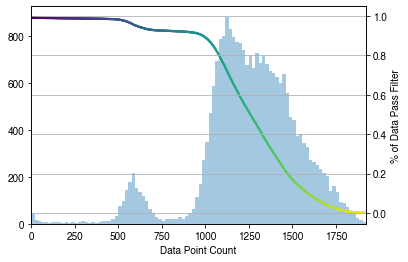

In [12]:
# only calculate CHN

fig, axes = cutoff_vs_cell_remain(mcds[f'{clustering_feature}_da']\
                                  .sel(count_type='cov', mc_type='CHN')\
                                  .mean(axis=0)\
                                  .load())
fig.savefig(fig_dir / f'region_mean_CHN_cov.pdf')

In [13]:
before = mcds.coords[clustering_feature].size
mcds = mcds.filter_region_cov(dim=clustering_feature,
                              da=f'{clustering_feature}_da',
                              mc_type='CHN',
                              min_cov=min_feature_cov,
                              max_cov=max_feature_cov)
after = mcds.coords[clustering_feature].size
print(
    f'Filter {clustering_feature} by [{min_feature_cov}, {max_feature_cov}], '
    f'filter rate {(after / before):.2f}. {after} features remained.')

Filter chrom100k by [500, 3000], filter rate 0.98. 23952 features remained.


## Add mC rate

In [14]:
mcds.add_mc_rate(dim=clustering_feature, da=f'{clustering_feature}_da')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-f04440fc2ee3>", line 1, in <module>
    mcds.add_mc_rate(dim=clustering_feature, da=f'{clustering_feature}_da')
  File "/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ALLCools/mcds/MCDS.py", line 203, in add_mc_rate
    clip_norm_value=clip_norm_value)
  File "/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ALLCools/mcds/utilities.py", line 18, in calculate_posterior_mc_rate
    cell_rate_mean = raw_rate.mean(dim=var_dim)  # this skip na
  File "/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/common.py", line 34, in wrapped_func
    skipna=skipna, allow_lazy=True, **kwargs)
  File "/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/dataarray

KeyboardInterrupt: 

In [17]:
mcds['chrom100k_da_rate'].to_netcdf('Adata/chrom100k_da_rate.nc')

## Select HVF

### mCH HVF

In [16]:
ch_hvf_df = mcds.highly_variable_methylation_feature(
    var_dim=clustering_feature,
    mc_type='CHN',
    min_disp=None,
    max_disp=None,
    min_mean=min_ch_hvf_mean,
    max_mean=max_ch_hvf_mean,
    n_top_feature=ch_hvf_top,
    bin_min_features=5,
    mean_binsize=0.05,
    cov_binsize=100)

Total Feature Number:     23952
Highly Variable Feature:  2999 (12.5%)


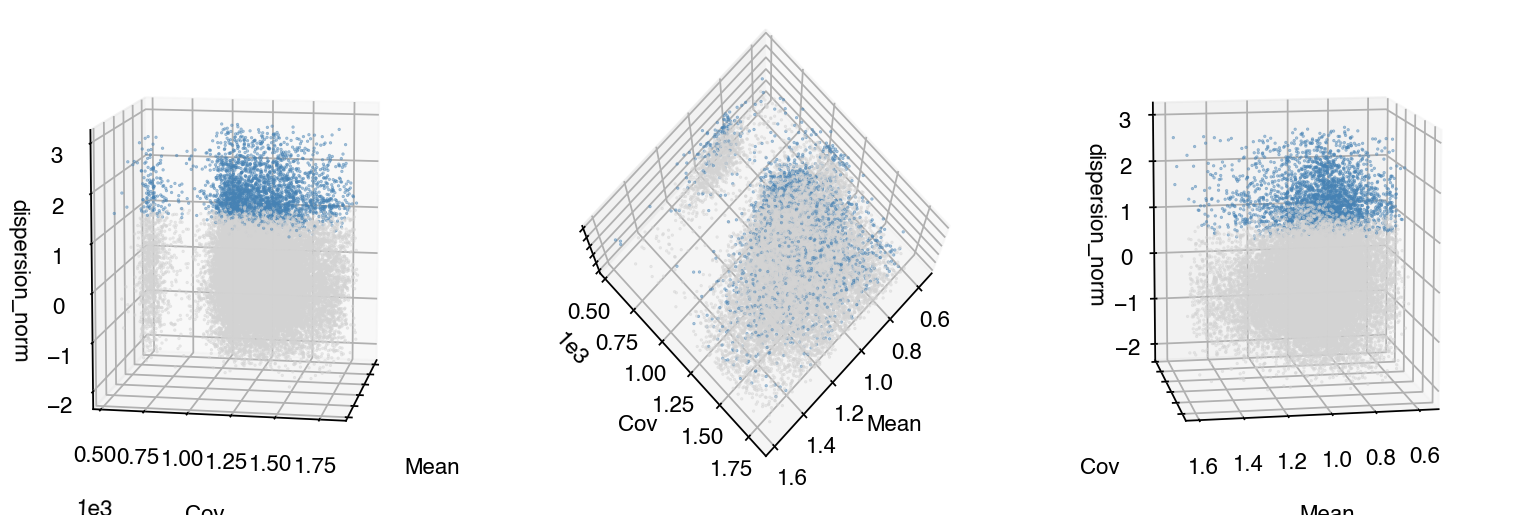

In [17]:
selection = ch_hvf_df['gene_subset']
print(f'Total Feature Number:     {selection.size}')
print(
    f'Highly Variable Feature:  {selection.sum()} ({(selection.sum() / selection.size * 100):.1f}%)'
)

fig, axes = plot_dispersion(ch_hvf_df,
                            hue='gene_subset',
                            zlab='dispersion_norm',
                            data_quantile=(0.01, 0.99),
                            save_animate_path=None,
                            fig_kws=None)
fig.savefig(fig_dir / f'ch_highly_variable_feature.{clustering_feature}.png',
            bbox_inches='tight')

### mCG HVF

In [18]:
cg_hvf_df = mcds.highly_variable_methylation_feature(
    var_dim=clustering_feature,
    mc_type='CGN',
    min_disp=None,
    max_disp=None,
    min_mean=min_cg_hvf_mean,
    max_mean=max_cg_hvf_mean,
    n_top_feature=cg_hvf_top,
    bin_min_features=5,
    mean_binsize=0.01,
    cov_binsize=10)

Total Feature Number:     23952
Highly Variable Feature:  2999 (12.5%)


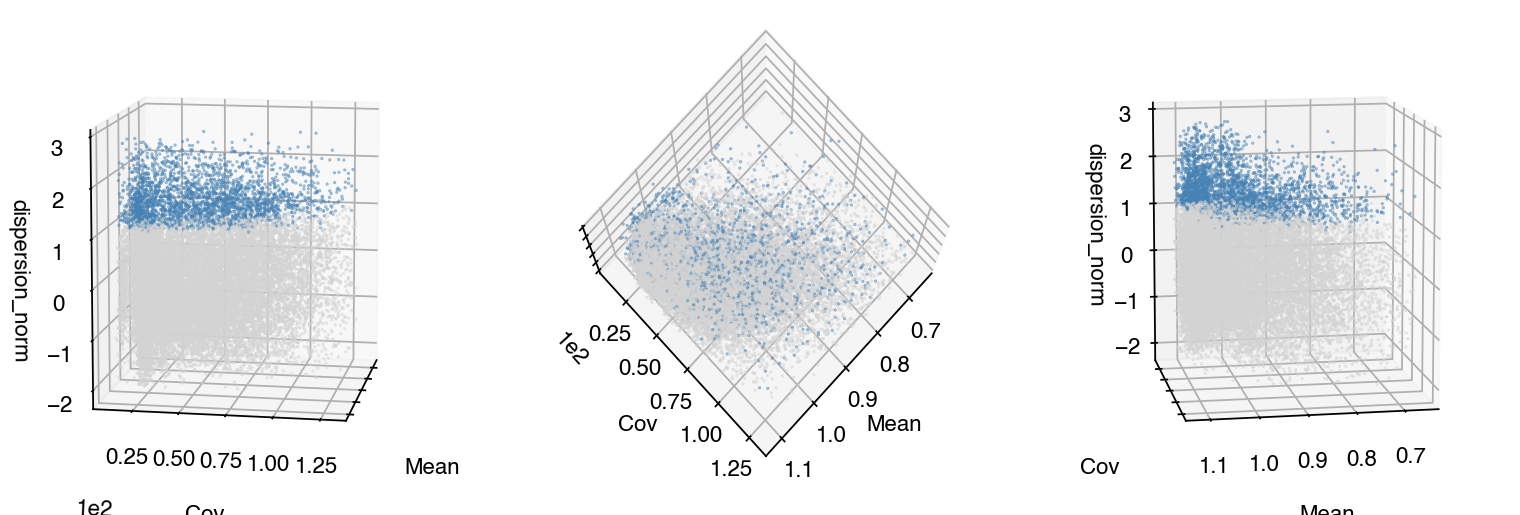

In [19]:
selection = cg_hvf_df['gene_subset']
print(f'Total Feature Number:     {selection.size}')
print(
    f'Highly Variable Feature:  {selection.sum()} ({(selection.sum() / selection.size * 100):.1f}%)'
)

fig, axes = plot_dispersion(cg_hvf_df,
                            hue='gene_subset',
                            zlab='dispersion_norm',
                            data_quantile=(0.01, 0.99),
                            save_animate_path=None,
                            fig_kws=None)
fig.savefig(fig_dir / f'cg_highly_variable_feature.{clustering_feature}.png',
            bbox_inches='tight')

## Get Anndata

### Load HVF

In [20]:
selected_ch_feature = ch_hvf_df[ch_hvf_df['gene_subset']].index
selected_cg_feature = cg_hvf_df[cg_hvf_df['gene_subset']].index

mcds = mcds.sel(chrom100k=(selected_ch_feature | selected_cg_feature))
mcds['chrom100k_da_rate'].load()

<xarray.DataArray 'chrom100k_da_rate' (cell: 5398, chrom100k: 5453, mc_type: 2)>
array([[[1.034188, 0.475616],
        [0.743418, 0.675303],
        ...,
        [1.109494, 0.470815],
        [0.985807, 0.048365]],

       [[0.870894, 1.187527],
        [1.033899, 0.506081],
        ...,
        [0.870894, 0.801996],
        [1.083217, 0.419022]],

       ...,

       [[0.97709 , 0.275926],
        [0.988582, 0.944575],
        ...,
        [1.098171, 0.07332 ],
        [0.943181, 1.28524 ]],

       [[1.18295 , 1.130342],
        [1.087791, 1.537071],
        ...,
        [1.088044, 0.320991],
        [0.849707, 0.519398]]])
Coordinates:
  * mc_type              (mc_type) object 'CGN' 'CHN'
    strand_type          <U4 'both'
  * cell                 (cell) object 'CEMBA191126-9J-1-CEMBA191126-9J-2-A10_ad010' ... 'CEMBA191127-11F-5-CEMBA191126-HCV-9-H9_ad010'
  * chrom100k            (chrom100k) int64 33 34 35 36 ... 26320 26326 26332
    chrom100k_chrom      (chrom100k) object 'chr1'

### CH adata

In [21]:
ch_adata = mcds.sel(chrom100k=selected_ch_feature).to_ann(
    f'{clustering_feature}_da_rate', var_dim=clustering_feature, mc_type='CHN')
ch_adata.write_h5ad(result_dir / 'mch_adata.norm_per_cell.hvf.h5ad')

Transforming to str index.


In [22]:
ch_adata

AnnData object with n_obs × n_vars = 5398 × 2999 

### CG adata

In [23]:
cg_adata = mcds.sel(chrom100k=selected_cg_feature).to_ann(
    f'{clustering_feature}_da_rate', var_dim=clustering_feature, mc_type='CGN')
cg_adata.write_h5ad(result_dir / 'mcg_adata.norm_per_cell.hvf.h5ad')

Transforming to str index.


In [24]:
cg_adata

AnnData object with n_obs × n_vars = 5398 × 2999 

## Prepare Gene

In [28]:
mcds = mcds.rename({
    'geneslop2k_da': 'gene_da',
    'geneslop2k': 'gene',
    'geneslop2k_chrom': 'gene_chrom',
    'geneslop2k_start': 'gene_start',
    'geneslop2k_end': 'gene_end'
})

In [29]:
if (clustering_feature != 'gene') and generate_gene_rate:
    mcds.add_gene_rate(in_memory=False,
                       output_prefix=str(result_dir / 'SelectedCell'),
                       cell_chunks=10000)